**TOKENIZATION** 

First step of our journey is to TOKENIZE our Emails.

In [147]:
import csv
import re
import os
import joblib


Deleting the bad format inputs and return every words in the document.

In [74]:
def tokenize_email(text):
    words = re.findall(r'[a-zA-Z0-9]+', text)
    return [word.lower() for word in words]


Proccessing the .CSV input file.

In [75]:
input_path = './data/emails.csv'
output_path = './data/emails_tokenized.csv'

with open(input_path, 'r', encoding='utf-8') as infile, \
     open(output_path, 'w', encoding='utf-8', newline='') as outfile:

    reader = csv.reader(infile)
    writer = csv.writer(outfile)
    
    writer.writerow(['tokens', 'spam'])
    
    next(reader, None)
    
    for row in reader:
        if len(row) < 2:
            continue
            
        text, label = row[0], row[1]
        tokens = tokenize_email(text)
        
        writer.writerow([tokens, label])

print("All done and saved in ",output_path)

All done and saved in  ./data/emails_tokenized.csv


**VECTORIZATION**



In [76]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import save_npz

Reading the tokenized data and transforming it to **LIST**

In [77]:

tokenized_path = './data/emails_tokenized.csv'
df = pd.read_csv(tokenized_path)

df['tokens'] = df['tokens'].apply(eval)

vectorizing features with 2 way 

**#1** Count Vectorization

In [78]:
count_vectorizer = CountVectorizer(
    tokenizer=lambda x: x,  # استفاده از توکن‌های از پیش پردازش شده
    preprocessor=lambda x: x,  # عدم پیش‌پردازش اضافی
    binary=False,  # حالت شمارشی
    min_df=2  # نادیده گرفتن کلماتی که کمتر از ۲ بار ظاهر شده‌اند
)
X_count = count_vectorizer.fit_transform(df['tokens'])

/home/acontius/amin/Bamdad_Ai/Bamdad/lib/python3.13/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


**#2** Binarry Vectorization

In [79]:
binary_vectorizer = CountVectorizer(
    tokenizer=lambda x: x,
    preprocessor=lambda x: x,
    binary=True, 
    min_df=2
)
X_binary = binary_vectorizer.fit_transform(df['tokens'])

Saving the **results** 

In [80]:
save_npz('./data/features_count.npz', X_count)
save_npz('./data/features_binary.npz', X_binary)


np.save('./data/labels.npy', df['spam'].values)


vocabulary = count_vectorizer.get_feature_names_out()
pd.Series(vocabulary).to_csv('./data/vocabulary.csv', index=False)

In [81]:
print(f"All features : {len(vocabulary)}")
print(f"Count : {X_count.shape}")
print(f"Binarry : {X_binary.shape}")

All features : 20303
Count : (5728, 20303)
Binarry : (5728, 20303)


In [82]:
from scipy.sparse import csr_matrix
import numpy as np

small_count = X_count[:5, :10].toarray()
small_binary = X_binary[:5, :10].toarray()

print("Count Matrix Sample:")
print(small_count)
print("\nBinary Matrix Sample:")
print(small_binary)

Count Matrix Sample:
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]

Binary Matrix Sample:
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


Generating a high res fig of our data

In [83]:
from pathlib import Path
import matplotlib.pyplot as plt

In [84]:
IMAGES_PATH = Path() / "images"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

**Data itself**

In [85]:
print(df)

                                                 tokens  spam
0     [subject, naturally, irresistible, your, corpo...     1
1     [subject, the, stock, trading, gunslinger, fan...     1
2     [subject, unbelievable, new, homes, made, easy...     1
3     [subject, 4, color, printing, special, request...     1
4     [subject, do, not, have, money, get, software,...     1
...                                                 ...   ...
5723  [subject, re, research, and, development, char...     0
5724  [subject, re, receipts, from, visit, jim, than...     0
5725  [subject, re, enron, case, study, update, wow,...     0
5726  [subject, re, interest, david, please, call, s...     0
5727  [subject, news, aurora, 5, 2, update, aurora, ...     0

[5728 rows x 2 columns]


**Value Count**

In [86]:
print(df['spam'].value_counts())
print(df.columns)

spam
0    4360
1    1368
Name: count, dtype: int64
Index(['tokens', 'spam'], dtype='object')


# Generating Fig

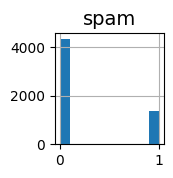

In [87]:
# extra code – the next 5 lines define the default font sizes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

df.hist(bins=10, figsize=(2, 2))
save_fig("attribute_histogram_plots")  # extra code
plt.show()

**Ceate a Test Set**

In [88]:
def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [89]:
train_set, test_set = shuffle_and_split_data(df, 0.2)
print(len(train_set),len(test_set))

4583 1145


In [90]:
print(df.applymap)

<bound method DataFrame.applymap of                                                  tokens  spam
0     [subject, naturally, irresistible, your, corpo...     1
1     [subject, the, stock, trading, gunslinger, fan...     1
2     [subject, unbelievable, new, homes, made, easy...     1
3     [subject, 4, color, printing, special, request...     1
4     [subject, do, not, have, money, get, software,...     1
...                                                 ...   ...
5723  [subject, re, research, and, development, char...     0
5724  [subject, re, receipts, from, visit, jim, than...     0
5725  [subject, re, enron, case, study, update, wow,...     0
5726  [subject, re, interest, david, please, call, s...     0
5727  [subject, news, aurora, 5, 2, update, aurora, ...     0

[5728 rows x 2 columns]>


In [91]:
np.random.seed(42)

In [92]:
from zlib import crc32

In [93]:
def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [94]:
emails_with_id = df.reset_index()  # adds an `index` column
train_set, test_set = split_data_with_id_hash(emails_with_id, 0.2, "index")

In [95]:
df['index'] = df.index

In [96]:
emails_with_id["id"] = df['index'] * 1000 + df['spam']
train_set, test_set = split_data_with_id_hash(emails_with_id, 0.2, "id")

In [97]:
from sklearn.model_selection import train_test_split

In [98]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

**Visualization**

!Making a copy of train to the df to not letting the model to see the tests.

In [99]:
df = train_set.copy()

calculating email's length and seperate spams and hams!

In [100]:
spam_counts = df['spam'].value_counts().reset_index()
spam_counts.columns = ['spam', 'count']

Creating the plot and save it !

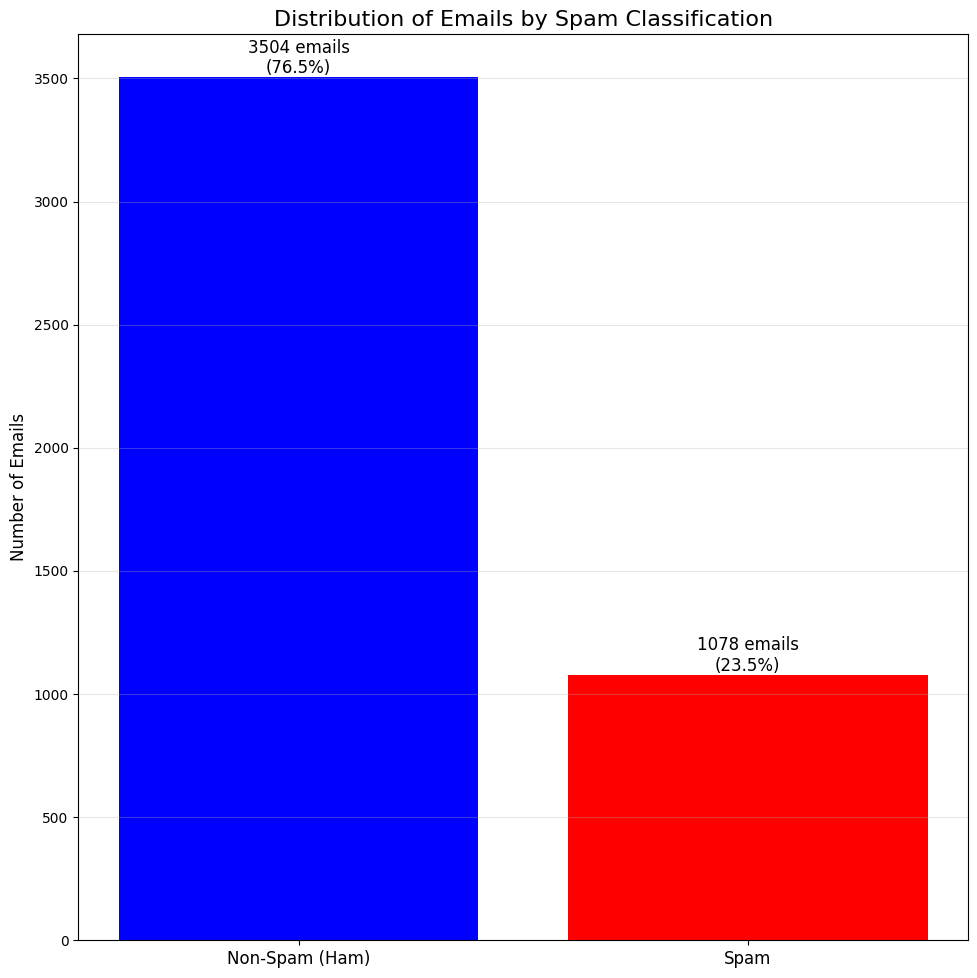

In [101]:
plt.figure(figsize=(10, 10))
bars = plt.bar(['Non-Spam (Ham)', 'Spam'], 
               spam_counts['count'], 
               color=['blue', 'red'])

# Add count labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height} emails\n({height/len(df)*100:.1f}%)',
             ha='center', va='bottom', fontsize=12)

# Add plot elements
plt.title('Distribution of Emails by Spam Classification', fontsize=16)
plt.ylabel('Number of Emails', fontsize=12)
plt.xticks(fontsize=12)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig("./images/email_counts.png", dpi=300)
plt.show()

Extra code for Future if we could use the date or time for better experience!


In [102]:
# # Convert to datetime if needed
# # df['date'] = pd.to_datetime(df['date'])

# # Group by time period (e.g., daily counts)
# daily_counts = df.groupby([df['date'].dt.date, 'spam']).size().unstack()

# # Plot time series
# daily_counts.plot(figsize=(12, 6), color=['blue', 'red'])
# plt.title('Daily Email Counts by Classification')
# plt.ylabel('Number of Emails')
# plt.grid(alpha=0.3)
# plt.savefig("daily_email_counts.png")
# plt.show()

this code is written by AI to for correlations and finding most used words in spams!

Original X_binary shape: (5728, 20303)
Original y shape: (4582,)

Dimension mismatch detected! Re-aligning data...
Recreating vectorizer with current data...


/home/acontius/amin/Bamdad_Ai/Bamdad/lib/python3.13/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


New X_binary shape: (4582, 18076)
New y shape: (4582,)

Computing phi coefficients...
Phi coefficient calculation complete!

Top 10 spam indicators:
           word       phi
17297     vince  0.538304
6419      enron  0.500109
3712         cc  0.431096
8497          i  0.424914
9503   kaminski  0.397970
2070         am  0.351010
12675        pm  0.348578
396        2000  0.344282
6080        ect  0.343242
13551        re  0.332392

Top 10 ham indicators:
             word  phi
13838    reliably  0.0
13800  reinstated  0.0
13799   reinstate  0.0
13826    relaxing  0.0
3076           bl  0.0
3072       bjarne  0.0
3069       bitter  0.0
3067       bitmap  0.0
13844      relies  0.0
10272      lpharr  0.0


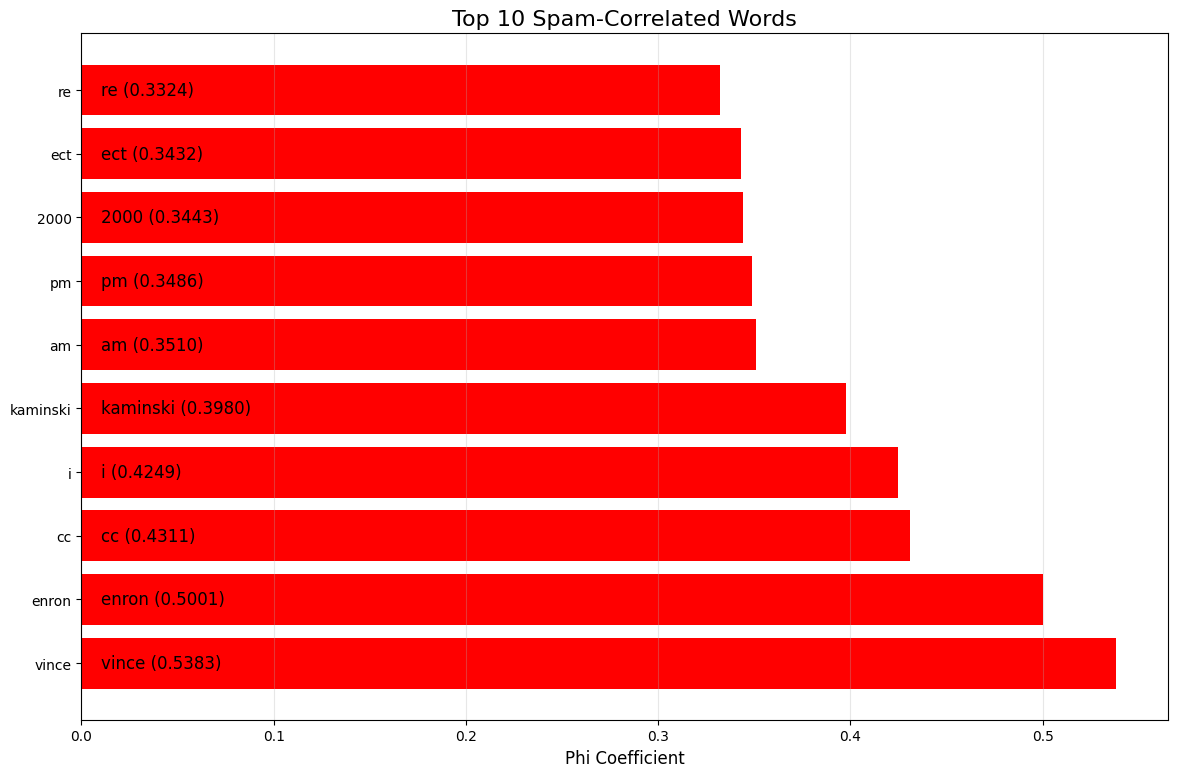

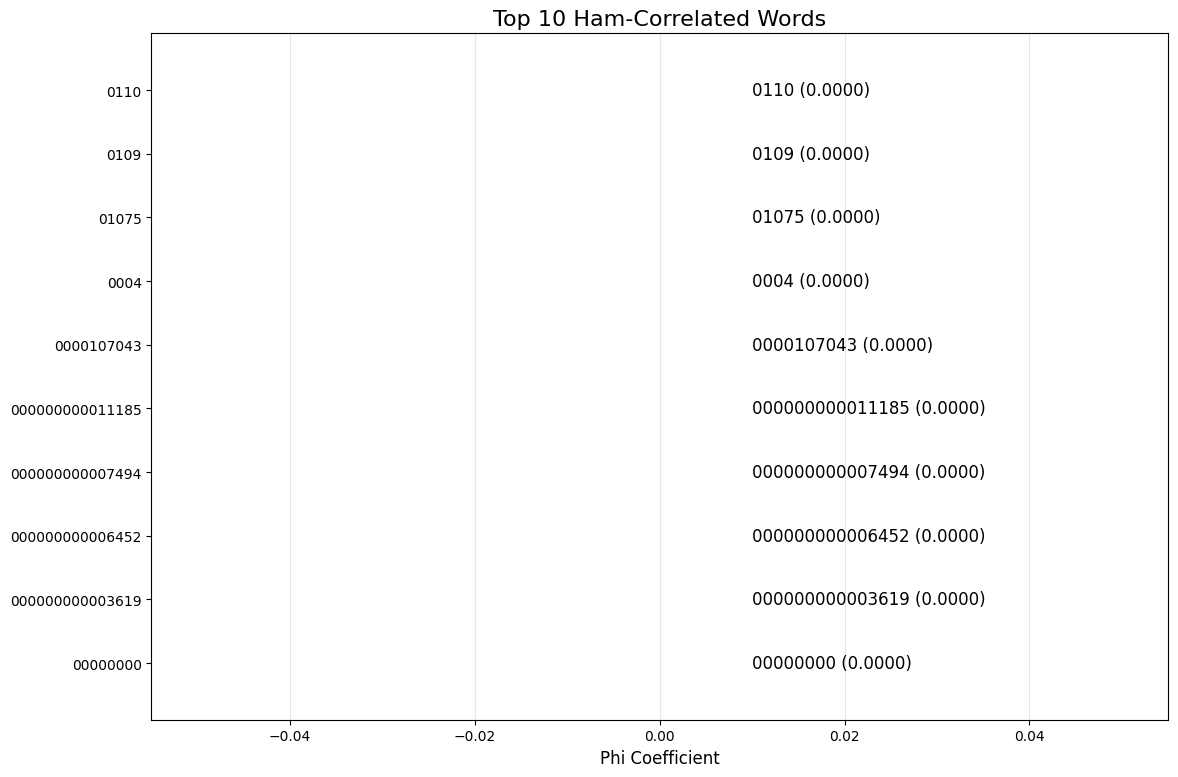

Correlation analysis completed successfully!


In [103]:
from scipy.stats import chi2_contingency
from sklearn.feature_extraction.text import CountVectorizer

# 1. Verify dimensions
print(f"Original X_binary shape: {X_binary.shape}")
print(f"Original y shape: {df['spam'].values.shape}")

# 2. Fix dimension mismatch
if X_binary.shape[0] != len(df):
    print("\nDimension mismatch detected! Re-aligning data...")
    
    # Reset indices to ensure alignment
    df = df.reset_index(drop=True)
    
    # Recreate vectorizer with fixed data
    print("Recreating vectorizer with current data...")
    binary_vectorizer = CountVectorizer(
        tokenizer=lambda x: x,
        preprocessor=lambda x: x,
        binary=True,
        min_df=2
    )
    X_binary = binary_vectorizer.fit_transform(df['tokens'])
    print(f"New X_binary shape: {X_binary.shape}")
    print(f"New y shape: {df['spam'].values.shape}")

# 3. Optimized phi coefficient calculation
def phi_coefficient(X, y):
    """Compute phi coefficients efficiently"""
    n_features = X.shape[1]
    phi = np.zeros(n_features)
    
    # Precompute y conditions
    y1 = (y == 1)  # Spam emails
    y0 = (y == 0)  # Ham emails
    
    for i in range(n_features):
        # Convert sparse column to dense array
        feature_col = X[:, i]
        feature_present = feature_col.toarray().flatten().astype(bool)
        
        # Build contingency table
        tp = np.sum(feature_present & y1)  # Spam with word
        tn = np.sum(~feature_present & y0)  # Ham without word
        fp = np.sum(feature_present & y0)  # Ham with word
        fn = np.sum(~feature_present & y1)  # Spam without word
        
        # Skip if no variation
        if tp + fp == 0 or tn + fn == 0:
            phi[i] = 0
            continue
            
        contingency = np.array([[tp, fp], [fn, tn]])
        try:
            chi2, _, _, _ = chi2_contingency(contingency)
            n = np.sum(contingency)
            phi[i] = np.sqrt(chi2 / n) if n > 0 else 0
        except:
            phi[i] = 0
            
    return phi

# 4. Compute phi coefficients
print("\nComputing phi coefficients...")
phi_values = phi_coefficient(X_binary, df['spam'].values)
print("Phi coefficient calculation complete!")

# 5. Create results dataframe
vocab = binary_vectorizer.get_feature_names_out()
phi_df = pd.DataFrame({'word': vocab, 'phi': phi_values})

# 6. Show top correlations
print("\nTop 10 spam indicators:")
print(phi_df.sort_values('phi', ascending=False).head(10))

print("\nTop 10 ham indicators:")
print(phi_df.sort_values('phi').head(10))

# 7. Visualize top correlations
# Top 10 spam words
top_spam = phi_df.nlargest(10, 'phi')
plt.figure(figsize=(12, 8))
plt.barh(top_spam['word'], top_spam['phi'], color='red')
plt.title('Top 10 Spam-Correlated Words', fontsize=16)
plt.xlabel('Phi Coefficient', fontsize=12)
plt.grid(axis='x', alpha=0.3)

# Add value labels
for i, (word, phi) in enumerate(zip(top_spam['word'], top_spam['phi'])):
    plt.text(0.01, i, f'{word} ({phi:.4f})', va='center', fontsize=12)

plt.tight_layout()
save_fig("top_spam_words")
plt.show()

# Top 10 ham words
top_ham = phi_df.nsmallest(10, 'phi')
plt.figure(figsize=(12, 8))
plt.barh(top_ham['word'], top_ham['phi'], color='blue')
plt.title('Top 10 Ham-Correlated Words', fontsize=16)
plt.xlabel('Phi Coefficient', fontsize=12)
plt.grid(axis='x', alpha=0.3)

# Add value labels
for i, (word, phi) in enumerate(zip(top_ham['word'], top_ham['phi'])):
    plt.text(0.01, i, f'{word} ({phi:.4f})', va='center', fontsize=12)

plt.tight_layout()
save_fig("top_ham_words")
plt.show()

print("Correlation analysis completed successfully!")

**DATA CLEANING**

In [104]:
df = df.drop("index", axis=1)

no null was found !

In [105]:
df_null = df.isnull().any(axis=1)
df.loc[df_null].head()

,tokens,spam


# Class imbalanced Handling 

In [114]:
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from scipy import sparse

**1. loading the vectorized Datas**

In [115]:
X_binary = sparse.load_npz('./data/features_binary.npz')
y = np.load('./data/labels.npy')

**2. Split data before resampling (to prevent data leakage)**


In [116]:
X_train, X_test, y_train, y_test = train_test_split(
    X_binary, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

**3. Analyze original class distribution**

In [117]:
print("CLASS DISTRIBUTION ANALYSIS")
print(f"\nTotal emails: {len(y_train)}")
print(f"Ham (0): {np.sum(y_train == 0)} emails ({np.mean(y_train == 0)*100:.1f}%)")
print(f"Spam (1): {np.sum(y_train == 1)} emails ({np.mean(y_train == 1)*100:.1f}%)")
print(f"Imbalance ratio: {np.sum(y_train == 0)/np.sum(y_train == 1):.1f}:1")

print("\nAPPLYING RESAMPLING TECHNIQUES")

# Baseline (no resampling)
X_base, y_base = X_train, y_train

# Random Oversampling
oversampler = RandomOverSampler(random_state=42)
X_over, y_over = oversampler.fit_resample(X_train, y_train)

# Random Undersampling
undersampler = RandomUnderSampler(random_state=42)
X_under, y_under = undersampler.fit_resample(X_train, y_train)

# SMOTE (Synthetic Minority Oversampling)
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

results = {
    "Baseline": (X_base, y_base),
    "Random Oversampling": (X_over, y_over),
    "Random Undersampling": (X_under, y_under),
    "SMOTE": (X_smote, y_smote)
}

print("\nResampled class distributions:")
for name, (X, y) in results.items():
    ham_count = np.sum(y == 0)
    spam_count = np.sum(y == 1)
    total = len(y)
    
    print(f"\n{name}:")
    print(f"  Total emails: {total}")
    print(f"  Ham (0): {ham_count} ({ham_count/total*100:.1f}%)")
    print(f"  Spam (1): {spam_count} ({spam_count/total*100:.1f}%)")

CLASS DISTRIBUTION ANALYSIS

Total emails: 4582
Ham (0): 3488 emails (76.1%)
Spam (1): 1094 emails (23.9%)
Imbalance ratio: 3.2:1

APPLYING RESAMPLING TECHNIQUES

Resampled class distributions:

Baseline:
  Total emails: 4582
  Ham (0): 3488 (76.1%)
  Spam (1): 1094 (23.9%)

Random Oversampling:
  Total emails: 6976
  Ham (0): 3488 (50.0%)
  Spam (1): 3488 (50.0%)

Random Undersampling:
  Total emails: 2188
  Ham (0): 1094 (50.0%)
  Spam (1): 1094 (50.0%)

SMOTE:
  Total emails: 6976
  Ham (0): 3488 (50.0%)
  Spam (1): 3488 (50.0%)


**7. Visualize distributions ,resampled datasets and save**

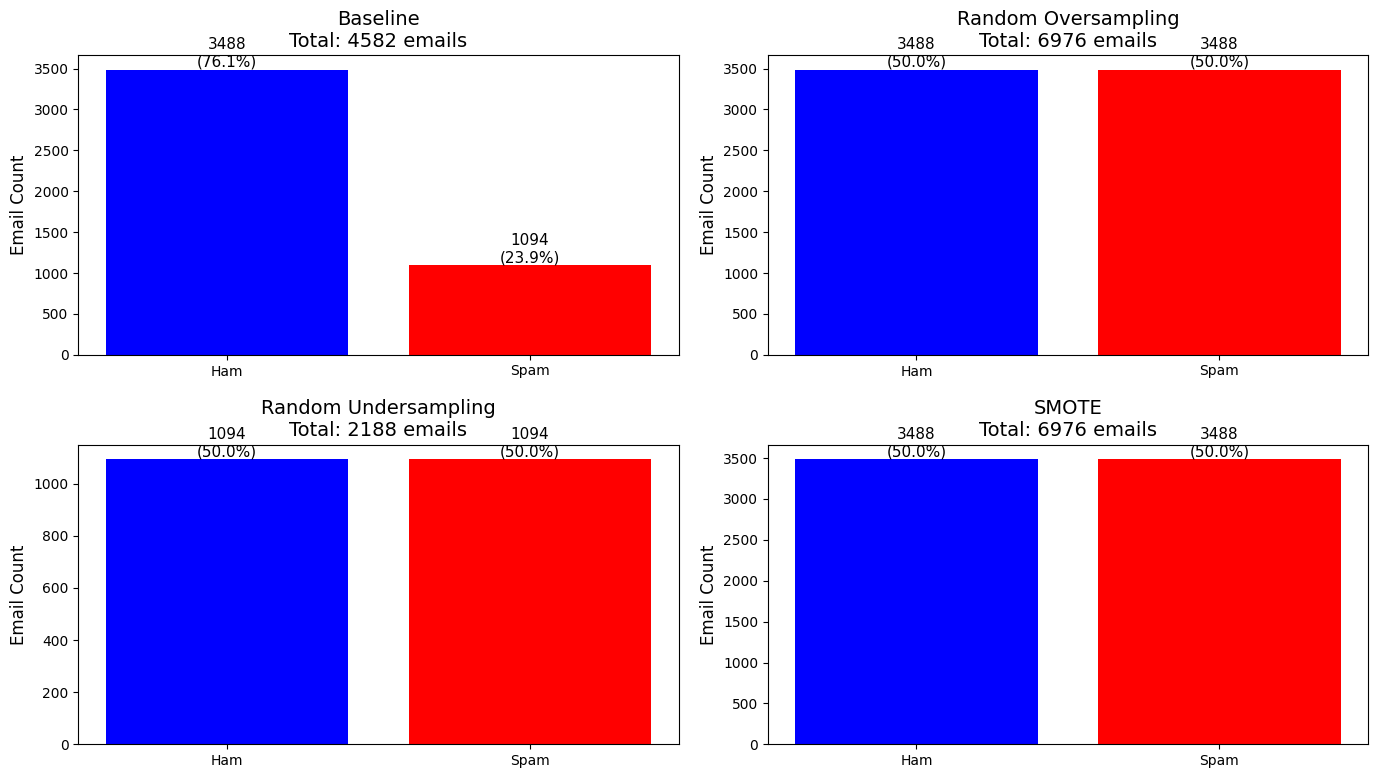

Saved Baseline dataset
Saved Random Oversampling dataset
Saved Random Undersampling dataset
Saved SMOTE dataset


In [118]:
plt.figure(figsize=(14, 8))
strategies = list(results.keys())

for i, strategy in enumerate(strategies, 1):
    _, y_data = results[strategy]
    ham_count = np.sum(y_data == 0)
    spam_count = np.sum(y_data == 1)
    
    plt.subplot(2, 2, i)
    bars = plt.bar(['Ham', 'Spam'], [ham_count, spam_count], color=['blue', 'red'])
    plt.title(f"{strategy}\nTotal: {len(y_data)} emails", fontsize=14)
    plt.ylabel('Email Count', fontsize=12)
    
    # Add count labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height}\n({height/len(y_data)*100:.1f}%)',
                ha='center', va='bottom', fontsize=11)

plt.tight_layout()
save_fig("class_balance_comparison")
plt.show()

os.makedirs('./data/resampled', exist_ok=True)

for name, (X, y) in results.items():
    # Convert name to filename-friendly format
    filename = name.lower().replace(' ', '_')
    
    sparse.save_npz(f'./data/resampled/X_{filename}.npz', X)
    
    np.save(f'./data/resampled/y_{filename}.npy', y)
    
    print(f"Saved {name} dataset")

# Feature Scaling

After handling class imbalance, there are just 2 essential steps left before training our classification models.

**Loading Datas and spliting it from tests!**

**Feature Scaling**

In [120]:
X_full = sparse.load_npz('./data/features_binary.npz')
y_full = np.load('./data/labels.npy')

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_full, y_full, 
    test_size=0.2, 
    stratify=y_full, 
    random_state=42
)

# Save test set
sparse.save_npz('./data/X_test.npz', X_test)
np.save('./data/y_test.npy', y_test)

print("Test set saved successfully!")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

Test set saved successfully!
X_test shape: (1146, 20303)
y_test shape: (1146,)


In [121]:
X_train = sparse.load_npz('./data/resampled/X_smote.npz')  # Example with SMOTE
y_train = np.load('./data/resampled/y_smote.npy')

X_test = sparse.load_npz('./data/X_test.npz')  # Should be saved from earlier
y_test = np.load('./data/y_test.npy')

In [125]:
from sklearn.preprocessing import StandardScaler

# models that need scaling (SVM, KNN, Logistic Regression)
scaler = StandardScaler(with_mean=False)  # Important for sparse matrices
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# tree-based models (Random Forest, Decision Tree) - no scaling needed
X_train_tree = X_train
X_test_tree = X_test

# Training Models

**importing required libs**

In [130]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
import time

**1. Load data**


In [131]:
print("Loading data...")
X_train = sparse.load_npz('./data/resampled/X_smote.npz')
y_train = np.load('./data/resampled/y_smote.npy')
X_test = sparse.load_npz('./data/X_test.npz')
y_test = np.load('./data/y_test.npy')

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Loading data...
Train shape: (6976, 20303), Test shape: (1146, 20303)


**2. Initialize models**

In [144]:
# n_estimators -> depth of the tree | n_jobs = -1 -> allows model to use all available CPU coers.
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "SVM": SVC(kernel='linear', random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Naive Bayes": MultinomialNB()
}

**3. Prepare scaling**

we have done this step before! gonna do this here to make sure ! 

In [145]:
scaler = StandardScaler(with_mean=False)  # Preserves sparsity

print("\nScaling features for SVM and KNN...")
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Scaling features for SVM and KNN...


**4. Train and evaluate models**

In [146]:
results = {}

for name, model in models.items():
    print(f"\n{'='*40}")
    print(f"Training {name}...")
    start_time = time.time()
    
    if name in ["SVM", "KNN"]:
        X_tr = X_train_scaled
        X_te = X_test_scaled
        print("Using scaled features")
    else:
        X_tr = X_train
        X_te = X_test
        print("Using raw features")
    
    model.fit(X_tr, y_train)
    train_time = time.time() - start_time
    
    # Evaluate
    start_time = time.time()
    y_pred = model.predict(X_te)
    test_time = time.time() - start_time
    
    # Store results
    results[name] = {
        "model": model,
        "train_time": train_time,
        "test_time": test_time,
        "report": classification_report(y_test, y_pred, target_names=['Ham', 'Spam'], output_dict=True),
        "confusion": confusion_matrix(y_test, y_pred)
    }
    
    # Print summary
    print(f"Training time: {train_time:.2f}s | Testing time: {test_time:.2f}s")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))


Training Random Forest...
Using raw features
Training time: 0.85s | Testing time: 0.06s
Classification Report:
              precision    recall  f1-score   support

         Ham       0.98      0.98      0.98       872
        Spam       0.94      0.93      0.94       274

    accuracy                           0.97      1146
   macro avg       0.96      0.96      0.96      1146
weighted avg       0.97      0.97      0.97      1146


Training SVM...
Using scaled features
Training time: 8.57s | Testing time: 1.18s
Classification Report:
              precision    recall  f1-score   support

         Ham       0.98      0.96      0.97       872
        Spam       0.88      0.92      0.90       274

    accuracy                           0.95      1146
   macro avg       0.93      0.94      0.94      1146
weighted avg       0.95      0.95      0.95      1146


Training KNN...
Using scaled features
Training time: 0.01s | Testing time: 0.60s
Classification Report:
              precision 

# Extra code 

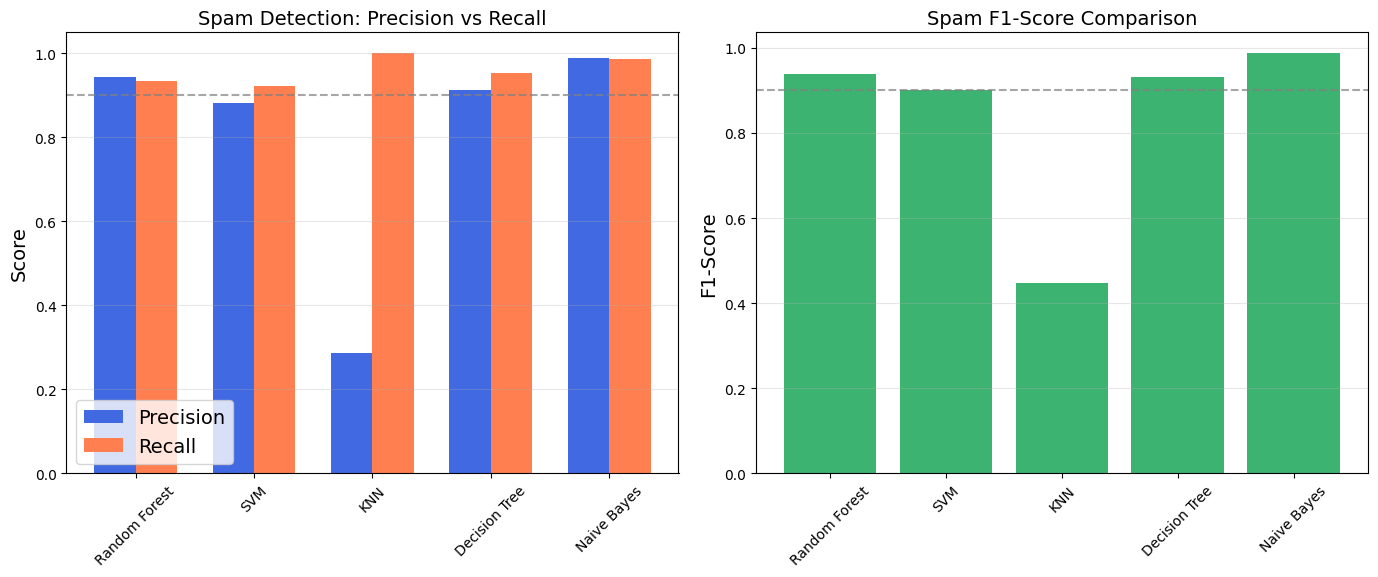

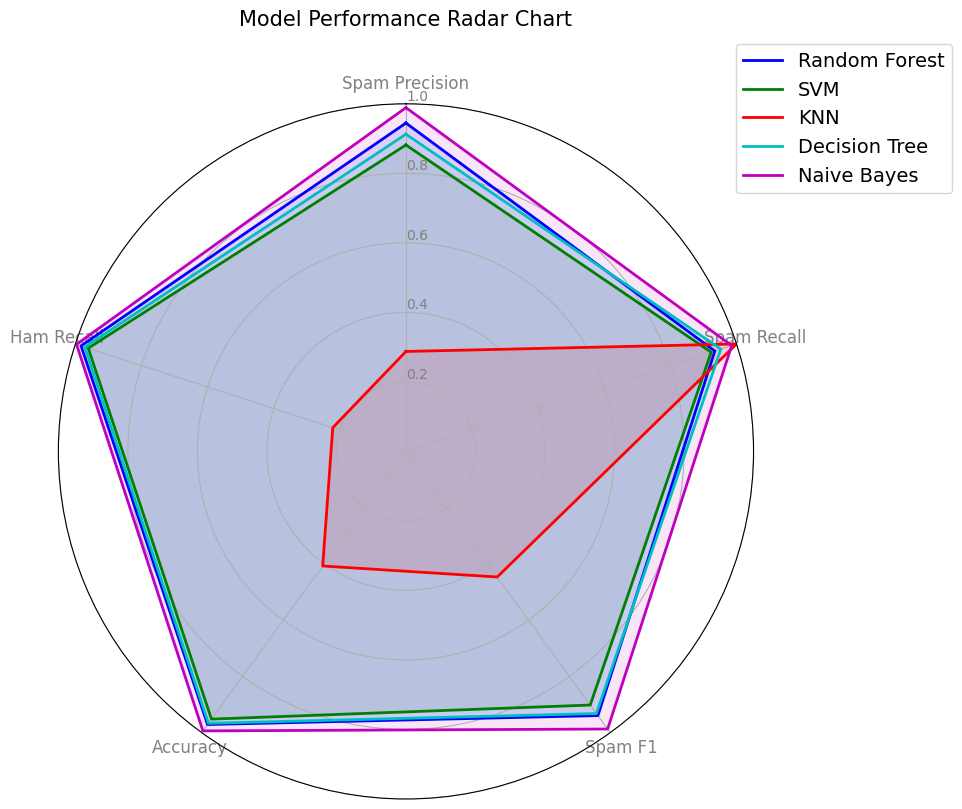

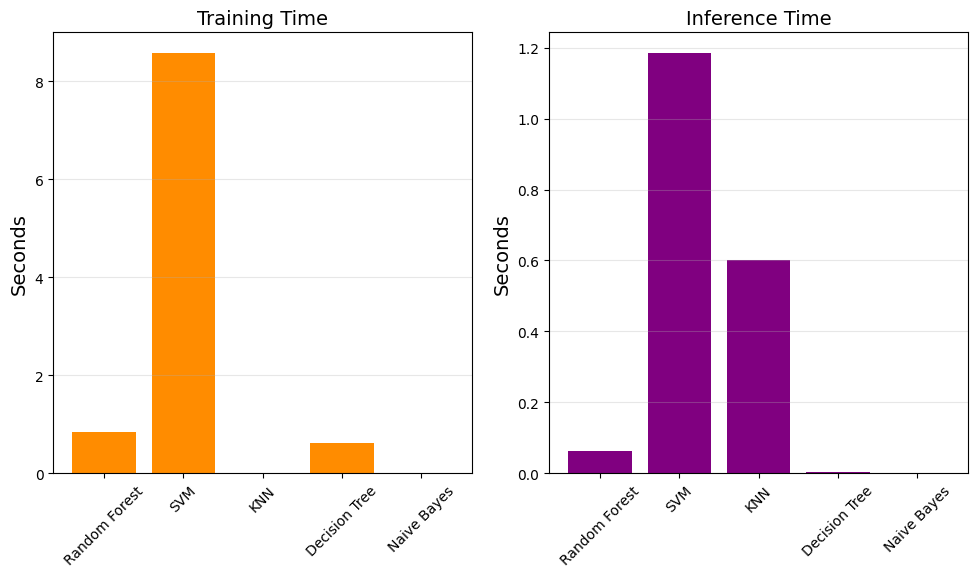

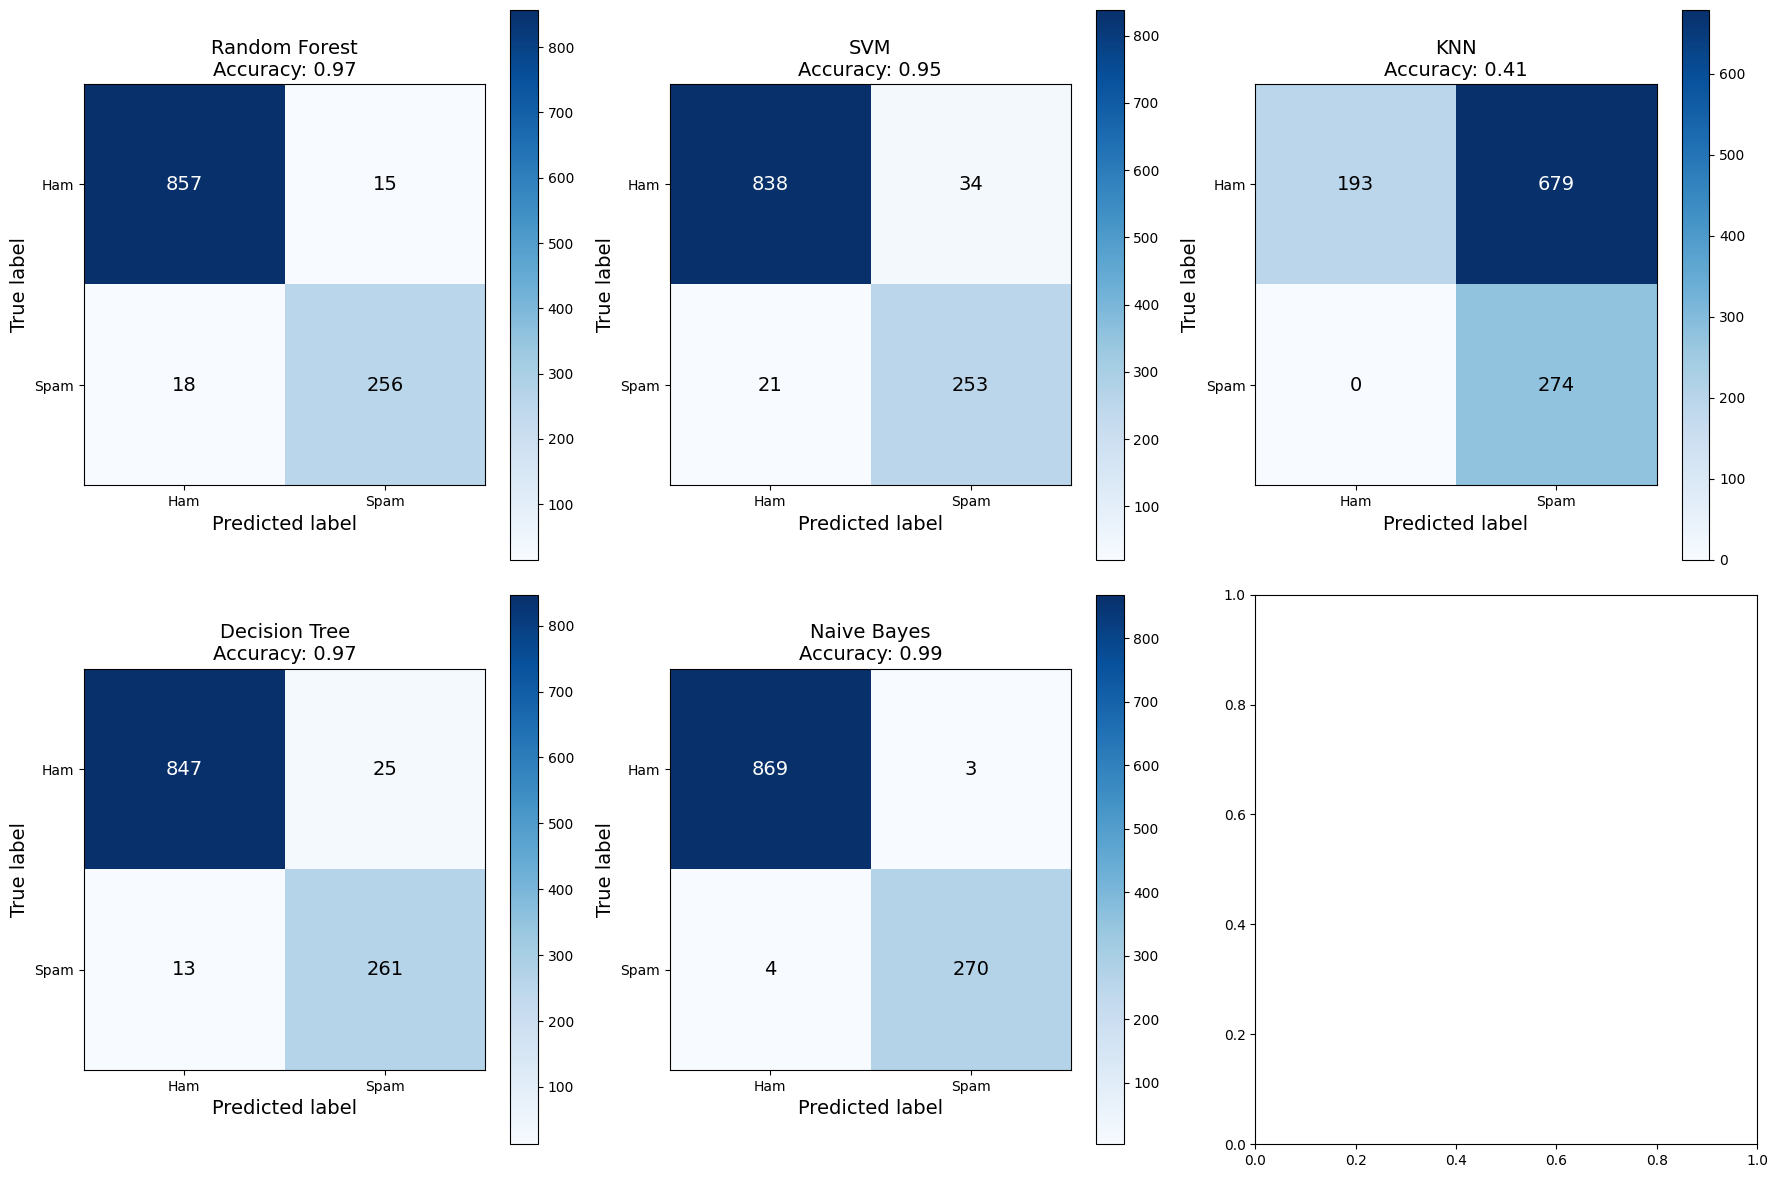

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

def save_fig(name):
    plt.savefig(f"{name}.png", dpi=300, bbox_inches='tight')

# ===== ROC Curve Comparison =====
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'orange']

for i, (name, res) in enumerate(results.items()):
    plt.plot(res['fpr'], res['tpr'], color=colors[i], lw=2,
             label=f'{name} (AUC = {res["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Ham incorrectly flagged as Spam)')
plt.ylabel('True Positive Rate (Spam correctly detected)')
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
save_fig("roc_curve_comparison")
plt.show()

# ===== Precision-Recall Curve Comparison =====
plt.figure(figsize=(10, 8))
for i, (name, res) in enumerate(results.items()):
    precision = res['report']['Spam']['precision']
    recall = res['report']['Spam']['recall']
    plt.plot(recall, precision, 'o-', color=colors[i], lw=2, 
             label=f'{name} (F1 = {res["report"]["Spam"]["f1-score"]:.2f})')

plt.xlabel('Recall (Spam Detection Rate)')
plt.ylabel('Precision (Accuracy of Spam Predictions)')
plt.title('Precision-Recall Tradeoff for Spam Detection', fontsize=14)
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
save_fig("precision_recall_tradeoff")
plt.show()

# ===== AUC Comparison =====
plt.figure(figsize=(12, 6))
auc_scores = [res['roc_auc'] for res in results.values()]
model_names = list(results.keys())

bars = plt.bar(model_names, auc_scores, color=colors[:len(model_names)])
plt.axhline(0.9, color='red', linestyle='--', alpha=0.7, label='Excellent (0.9)')
plt.axhline(0.8, color='orange', linestyle='--', alpha=0.7, label='Good (0.8)')
plt.axhline(0.7, color='green', linestyle='--', alpha=0.7, label='Fair (0.7)')
plt.ylim(0.5, 1.05)
plt.ylabel('AUC Score')
plt.title('Area Under ROC Curve (AUC) Comparison', fontsize=14)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}', ha='center', va='bottom', fontsize=11)

plt.legend(loc='lower right')
plt.grid(axis='y', alpha=0.3)
save_fig("auc_comparison")
plt.show()

# ===== Metrics Comparison =====
metrics = {
    'Ham Precision': [res['report']['Ham']['precision'] for res in results.values()],
    'Spam Precision': [res['report']['Spam']['precision'] for res in results.values()],
    'Ham Recall': [res['report']['Ham']['recall'] for res in results.values()],
    'Spam Recall': [res['report']['Spam']['recall'] for res in results.values()],
    'Ham F1': [res['report']['Ham']['f1-score'] for res in results.values()],
    'Spam F1': [res['report']['Spam']['f1-score'] for res in results.values()],
    'Accuracy': [res['report']['accuracy'] for res in results.values()],
    'Train Time': [res['train_time'] for res in results.values()],
    'Test Time': [res['test_time'] for res in results.values()]
}

# 1. Precision-Recall-F1 Comparison
fig, ax = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Model Performance Comparison', fontsize=16)

# Spam metrics
ax[0,0].bar(model_names, metrics['Spam Precision'], color='royalblue', alpha=0.7, label='Precision')
ax[0,0].bar(model_names, metrics['Spam Recall'], color='coral', alpha=0.7, label='Recall', bottom=metrics['Spam Precision'])
ax[0,0].set_title('Spam: Precision vs Recall')
ax[0,0].set_ylabel('Score')
ax[0,0].legend()

ax[0,1].bar(model_names, metrics['Spam F1'], color='mediumseagreen')
ax[0,1].set_title('Spam F1-Score')
ax[0,1].set_ylabel('F1-Score')

# Ham metrics
ax[1,0].bar(model_names, metrics['Ham Precision'], color='royalblue', alpha=0.7)
ax[1,0].bar(model_names, metrics['Ham Recall'], color='coral', alpha=0.7, bottom=metrics['Ham Precision'])
ax[1,0].set_title('Ham: Precision vs Recall')
ax[1,0].set_ylabel('Score')

ax[1,1].bar(model_names, metrics['Ham F1'], color='mediumseagreen')
ax[1,1].set_title('Ham F1-Score')
ax[1,1].set_ylabel('F1-Score')

plt.tight_layout(rect=[0, 0, 1, 0.96])
save_fig("precision_recall_f1_comparison")
plt.show()

# 2. Accuracy and Time Comparison
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Model Efficiency and Accuracy', fontsize=16)

# Accuracy
ax[0].bar(model_names, metrics['Accuracy'], color='purple')
ax[0].set_title('Accuracy')
ax[0].set_ylabel('Accuracy Score')

# Training Time
ax[1].bar(model_names, metrics['Train Time'], color='darkorange')
ax[1].set_title('Training Time (seconds)')
ax[1].set_ylabel('Seconds')

# Inference Time
ax[2].bar(model_names, metrics['Test Time'], color='teal')
ax[2].set_title('Inference Time (seconds)')
ax[2].set_ylabel('Seconds')

plt.tight_layout(rect=[0, 0, 1, 0.96])
save_fig("accuracy_time_comparison")
plt.show()

# ===== Confusion Matrix Grid =====
n_models = len(results)
ncols = min(3, n_models)
nrows = (n_models + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
fig.suptitle('Confusion Matrix Comparison', fontsize=16)

for i, (name, res) in enumerate(results.items()):
    if nrows > 1:
        ax = axes[i//ncols, i%ncols]
    else:
        ax = axes[i%ncols]
    
    cm = res.get('confusion_optimal', res['confusion'])
    im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
    
    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    ax.set_title(f'{name} (Acc: {res["report"]["accuracy"]:.3f})')
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['Ham', 'Spam'])
    ax.set_yticklabels(['Ham', 'Spam'])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

plt.tight_layout(rect=[0, 0, 1, 0.96])
save_fig("confusion_matrix_grid")
plt.show()

# ===== Threshold Analysis for Best Model =====
best_model_name = max(results, key=lambda x: results[x]['roc_auc'])
best_res = results[best_model_name]

if 'thresholds' in best_res:
    plt.figure(figsize=(12, 6))
    plt.plot(best_res['thresholds'], best_res['tpr'], 'b-', lw=2, label='Sensitivity (TPR)')
    plt.plot(best_res['thresholds'], 1 - best_res['fpr'], 'g-', lw=2, label='Specificity (TNR)')
    
    # Find optimal threshold
    youden_j = best_res['tpr'] - best_res['fpr']
    optimal_idx = np.argmax(youden_j)
    optimal_threshold = best_res['thresholds'][optimal_idx]
    
    plt.axvline(optimal_threshold, color='r', linestyle='--', 
                label=f'Optimal Threshold: {optimal_threshold:.2f}')
    plt.xlabel('Decision Threshold')
    plt.ylabel('Rate')
    plt.title(f'{best_model_name} Threshold Analysis\n(Optimal Balance at {optimal_threshold:.2f})', fontsize=14)
    plt.legend()
    plt.grid(alpha=0.3)
    save_fig(f"threshold_analysis_{best_model_name}")
    plt.show()

# Print best model details
print(f"\n{'='*50}")
print(f"BEST PERFORMING MODEL: {best_model_name}")
print(f"AUC: {best_res['roc_auc']:.4f}")
print(f"Accuracy: {best_res['report']['accuracy']:.4f}")
print(f"Spam F1-score: {best_res['report']['Spam']['f1-score']:.4f}")
print(f"{'='*50}\n")

# Print all metrics in table format
print("\nMODEL PERFORMANCE SUMMARY:")
print(f"{'Model':<15} {'Accuracy':<8} {'AUC':<8} {'Spam F1':<8} {'Train Time':<10} {'Test Time':<10}")
for name, res in results.items():
    print(f"{name:<15} {res['report']['accuracy']:.4f}  {res['roc_auc']:.4f}  " 
          f"{res['report']['Spam']['f1-score']:.4f}  {res['train_time']:.4f}s      {res['test_time']:.4f}s")

**5. Compare model performance**

In [137]:
print("MODEL PERFORMANCE SUMMARY\n")

# Print spam recall (most important metric)
print("\nSpam Recall Comparison:")
print("{:<15} {:<10} {:<10} {:<10}".format("Model", "Spam Recall", "Precision", "F1-Score"))
for name, res in results.items():
    spam_recall = res['report']['Spam']['recall']
    spam_precision = res['report']['Spam']['precision']
    spam_f1 = res['report']['Spam']['f1-score']
    print("{:<15} {:<10.4f} {:<10.4f} {:<10.4f}".format(name, spam_recall, spam_precision, spam_f1))

MODEL PERFORMANCE SUMMARY


Spam Recall Comparison:
Model           Spam Recall Precision  F1-Score  
Random Forest   0.9343     0.9446     0.9394    
SVM             0.9234     0.8815     0.9020    
KNN             1.0000     0.2875     0.4466    
Decision Tree   0.9526     0.9126     0.9321    
Naive Bayes     0.9854     0.9890     0.9872    



Saved Naive Bayes model to './models/spam_classifier_nb.pkl'


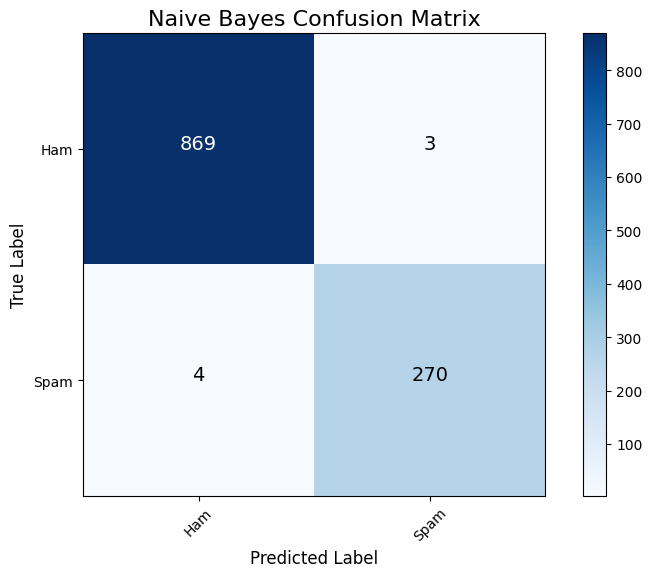


Naive Bayes Performance Summary:
- Accuracy: 0.9939
- Spam Precision: 0.9890
- Spam Recall: 0.9854
- Spam F1-Score: 0.9872


In [149]:
os.makedirs('./models', exist_ok=True)

# Save Naive Bayes model
joblib.dump(results["Naive Bayes"]["model"], './models/spam_classifier_nb.pkl')
print("\nSaved Naive Bayes model to './models/spam_classifier_nb.pkl'")


# 7. Visualize confusion matrix for best model
def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Add text annotations
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    save_fig(f"confusion_matrix_{title.replace(' ', '_').lower()}")
    plt.show()

# Plot for Naive Bayes
nb_confusion = results["Naive Bayes"]["confusion"]
plot_confusion_matrix(
    nb_confusion,
    classes=['Ham', 'Spam'],
    title='Naive Bayes Confusion Matrix'
)

# Print performance summary
print("\nNaive Bayes Performance Summary:")
print(f"- Accuracy: {results['Naive Bayes']['report']['accuracy']:.4f}")
print(f"- Spam Precision: {results['Naive Bayes']['report']['Spam']['precision']:.4f}")
print(f"- Spam Recall: {results['Naive Bayes']['report']['Spam']['recall']:.4f}")
print(f"- Spam F1-Score: {results['Naive Bayes']['report']['Spam']['f1-score']:.4f}")

**Hyperparameter Tuning with Cross-validation**

In [151]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, recall_score

**1. Define parameter grids for each model**

In [162]:
param_grids = {
    "Random Forest": {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'class_weight': ['balanced', None]
    },
    "SVM": {
        'model__C': np.logspace(-3, 3, 7),  # Add model__ prefix
        'model__kernel': ['linear', 'rbf', 'poly'],
        'model__gamma': ['scale', 'auto'] + list(np.logspace(-3, 1, 5))
    },
    "KNN": {
        'model__n_neighbors': range(3, 21, 2),
        'model__weights': ['uniform', 'distance'],
        'model__p': [1, 2]
    },
    "Decision Tree": {
        'max_depth': [None, 5, 10, 20, 30],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 2, 4, 8],
        'criterion': ['gini', 'entropy']
    },
    "Naive Bayes": {
        'alpha': [0.01, 0.1, 0.5, 1.0, 2.0],
        'fit_prior': [True, False]
    }
}

**2. Define models with base parameters**

In [163]:
base_models = {
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1),
    "SVM": SVC(random_state=42, probability=True),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Naive Bayes": MultinomialNB()
}

**3. Create scoring metric - prioritize spam recall and pipeline tuning**

In [164]:
scorer = make_scorer(recall_score, pos_label=1)  # Spam recall

tuned_models = {}
best_params = {}

for name in base_models.keys():
    print(f"\n{'='*60}")
    print(f"Tuning {name} hyperparameters...")
    print('='*60)
    
    if name in ["SVM", "KNN"]:
        # Create pipeline with scaler and model
        pipe = Pipeline([
            ('scaler', StandardScaler(with_mean=False)),
            ('model', base_models[name])
        ])
        X_tune = X_train
    else:
        # Use model directly (no pipeline)
        pipe = base_models[name]
        X_tune = X_train
    
    # Set up randomized search
    search = RandomizedSearchCV(
        pipe,
        param_grids[name],
        n_iter=20,
        cv=3,
        scoring=scorer,
        n_jobs=-1,
        random_state=42,
        verbose=1
    )
    
    # Run search
    search.fit(X_tune, y_train)
    
    # Store results
    tuned_models[name] = search.best_estimator_
    best_params[name] = search.best_params_
    
    print(f"Best parameters for {name}:")
    print(search.best_params_)
    print(f"Best spam recall (CV): {search.best_score_:.4f}")


Tuning Random Forest hyperparameters...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters for Random Forest:
{'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 10, 'class_weight': 'balanced'}
Best spam recall (CV): 0.9321

Tuning SVM hyperparameters...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


KeyboardInterrupt: 

**4. Evaluate tuned models on test set**


In [ ]:
print("\n\n" + "="*60)
print("Evaluating Tuned Models on Test Set")
print("="*60)

tuned_results = {}
for name, model in tuned_models.items():
    print(f"\nEvaluating {name}...")
    
    if name in ["SVM", "KNN"]:
        X_te = X_test_scaled
    else:
        X_te = X_test
    
    # Predict
    y_pred = model.predict(X_te)
    
    # Store results
    tuned_results[name] = {
        "report": classification_report(y_test, y_pred, target_names=['Ham', 'Spam'], output_dict=True),
        "confusion": confusion_matrix(y_test, y_pred)
    }
    
    # Print spam recall
    spam_recall = recall_score(y_test, y_pred, pos_label=1)
    print(f"Test Spam Recall: {spam_recall:.4f}")

**5. Compare with original models**

In [ ]:
print("\n\n" + "="*60)
print("Performance Comparison: Original vs Tuned Models")
print("="*60)
print("{:<15} {:<10} {:<10}".format("Model", "Original Recall", "Tuned Recall"))

for name in tuned_results.keys():
    orig_recall = results[name]['report']['Spam']['recall']
    tuned_recall = tuned_results[name]['report']['Spam']['recall']
    print("{:<15} {:<10.4f} {:<10.4f} {:<+10.4f}".format(
        name, orig_recall, tuned_recall, tuned_recall - orig_recall
    ))

**6. Save best tuned model**

In [ ]:

best_tuned_name = max(tuned_results, 
                     key=lambda x: tuned_results[x]['report']['Spam']['recall'])
best_model = tuned_models[best_tuned_name]

joblib.dump(best_model, f'./models/spam_classifier_tuned_{best_tuned_name.lower().replace(" ", "_")}.pkl')
print(f"\nSaved best tuned model ({best_tuned_name}) to ./models/")